<a href="https://colab.research.google.com/github/dilanHewawitharana/Intro-to-Deep-Learning-with-PyTorch/blob/master/sample_common_notebook_for_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install opendatasets --upgrade --quiet

In [31]:
import opendatasets as od

In [32]:
od.download('https://www.kaggle.com/c/cassava-leaf-disease-classification')

cassava-leaf-disease-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


### Next extract the downloded data

In [33]:
import zipfile

with zipfile.ZipFile('cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

### Define directory paths

In [34]:
DATA_DIR = './data'

In [35]:
import os
os.listdir(DATA_DIR)

['train.csv',
 'train_images',
 'test_images',
 'test_tfrecords',
 'train_tfrecords',
 'label_num_to_disease_map.json',
 'sample_submission.csv']

In [36]:
TRAIN_DIR = DATA_DIR + '/train_images' # Contains training images
TEST_DIR = DATA_DIR + '/test_images' # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv' # Contains real labels for training images
TEST_CSV = DATA_DIR + '/sample_submission.csv' # Contains dummy labels for test image

### Exploring the Data
Get some idea about data

In [37]:
import pandas as pd

train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [38]:
len(train_df) # number of training data

21397

In [39]:
len(os.listdir(TRAIN_DIR)) # number of training images

21397

In [40]:
# types of labels in the dataset
labels  = pd.read_json(DATA_DIR + '/label_num_to_disease_map.json', 
                         orient='index')
labels 

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


### Creating Datasets & Data Loaders

In [41]:
from torch.utils.data import Dataset, random_split, DataLoader

class CassavaLeafDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image_id'], row['label']
        img_fname = self.root_dir + "/" + str(img_id)
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        # return img, encode_label(img_label))
        return img, img_label

In [42]:
import torchvision.transforms as transforms

# define transformations
transform = transforms.Compose([transforms.ToTensor()])
dataset = CassavaLeafDataset(TRAIN_CSV, TRAIN_DIR, transform=transform)

In [43]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    #print('Labels:', decode_target(target, text_labels=True))
    print('Label:', labels[0][int(target)])

Label: Cassava Mosaic Disease (CMD)


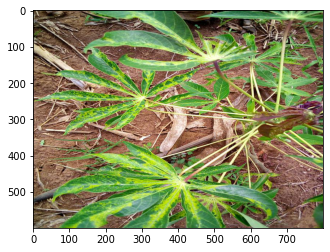

In [44]:
show_sample(*dataset[1], invert=False)

In [45]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [46]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(19258, 2139)

In [47]:
batch_size = 16

In [48]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [49]:
from torchvision.utils import make_grid

def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

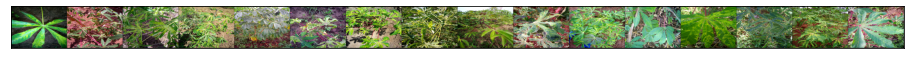

In [50]:
show_batch(train_dl)

### Helper function to analize the results

In [51]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def predict_single(image, target, model):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds.argmax(1)
    print("Prediction: ", prediction)
    print("Actual label: ",  labels[0][target])
    show_sample(image, prediction.int(), invert=False)

### GPU Utilities

In [52]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Model and Training Utilties

For single image classification

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

For Multi label Image Classification

In [54]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [55]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## cnn model - singleImage classification

In [57]:
class cnnModelSM(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 32 x 300 x 400

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 64 x 150 x 200

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 128 x 75 x 100

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 256 x 37 x 50

            # nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(4, 4), # output: 512 x 18 x 25

            nn.Flatten(), 
            nn.Linear(256*2*3, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 5)
            )
        
    def forward(self, xb):
        return self.network(xb)

## Train the model using cnn model

check for device

In [36]:
device = get_default_device()
device

device(type='cuda')

create cnn model object

In [37]:
cnnModelSm = cnnModelSM()
cnnModelSm

cnnModelSM(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

send model, train data loader and valid data loader to choosen device

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
cnnModelSm = to_device(cnnModelSm, device)

Check the model output for one batch

In [39]:
from torchsummary import summary

summary(cnnModelSm, (3, 600, 800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 600, 800]             448
              ReLU-2         [-1, 16, 600, 800]               0
            Conv2d-3         [-1, 32, 600, 800]           4,640
              ReLU-4         [-1, 32, 600, 800]               0
         MaxPool2d-5         [-1, 32, 150, 200]               0
            Conv2d-6         [-1, 64, 150, 200]          18,496
              ReLU-7         [-1, 64, 150, 200]               0
            Conv2d-8         [-1, 64, 150, 200]          36,928
              ReLU-9         [-1, 64, 150, 200]               0
        MaxPool2d-10           [-1, 64, 37, 50]               0
           Conv2d-11          [-1, 128, 37, 50]          73,856
             ReLU-12          [-1, 128, 37, 50]               0
           Conv2d-13          [-1, 128, 37, 50]         147,584
             ReLU-14          [-1, 128,

In [40]:
torch.cuda.empty_cache()

def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = cnnModelSm(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([16, 3, 600, 800])
out.shape: torch.Size([16, 5])
out[0]: tensor([ 0.0364, -0.0642,  0.0895,  0.0809,  0.0717], device='cuda:0',
       grad_fn=<SelectBackward>)


evaluate model without training and saved into history

In [41]:
history = None
history = [evaluate(cnnModelSm, val_dl)]
history

[{'val_acc': 0.11406508833169937, 'val_loss': 1.5896799564361572}]

Train parameters

In [42]:
num_epochs = 2
opt_func = torch.optim.Adam
lr = 1e-4

In [43]:
history += fit(num_epochs, lr, cnnModelSm, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1446, val_loss: 1.0069, val_acc: 0.6356
Epoch [1], train_loss: 0.9809, val_loss: 0.9252, val_acc: 0.6651


In [44]:
history += fit(num_epochs, lr, cnnModelSm, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.8836, val_loss: 0.8385, val_acc: 0.6796
Epoch [1], train_loss: 0.8372, val_loss: 0.8508, val_acc: 0.6881


In [45]:
history += fit(num_epochs, lr, cnnModelSm, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.7985, val_loss: 0.7690, val_acc: 0.7067
Epoch [1], train_loss: 0.7588, val_loss: 0.7641, val_acc: 0.7231


In [46]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 1e-3

In [47]:
history += fit(num_epochs, lr, cnnModelSm, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.9848, val_loss: 0.8585, val_acc: 0.6781
Epoch [1], train_loss: 0.8636, val_loss: 0.7814, val_acc: 0.6955
Epoch [2], train_loss: 0.8024, val_loss: 0.7505, val_acc: 0.7234


In [48]:
history += fit(num_epochs, lr, cnnModelSm, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.7594, val_loss: 0.7027, val_acc: 0.7332
Epoch [1], train_loss: 0.7105, val_loss: 0.6784, val_acc: 0.7470
Epoch [2], train_loss: 0.6639, val_loss: 0.7152, val_acc: 0.7379


In [49]:
num_epochs = 2
opt_func = torch.optim.Adam
lr = 1e-4

In [50]:
history += fit(num_epochs, lr, cnnModelSm, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.5372, val_loss: 0.5864, val_acc: 0.7930
Epoch [1], train_loss: 0.5054, val_loss: 0.5717, val_acc: 0.7935


In [51]:
history += fit(num_epochs, lr, cnnModelSm, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4837, val_loss: 0.5864, val_acc: 0.7856
Epoch [1], train_loss: 0.4648, val_loss: 0.5910, val_acc: 0.7925


In [52]:
num_epochs = 7
opt_func = torch.optim.Adam
lr = 1e-4

In [53]:
history += fit(num_epochs, lr, cnnModelSm, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4468, val_loss: 0.5877, val_acc: 0.7925
Epoch [1], train_loss: 0.4273, val_loss: 0.5876, val_acc: 0.7924
Epoch [2], train_loss: 0.4072, val_loss: 0.5894, val_acc: 0.7930
Epoch [3], train_loss: 0.3808, val_loss: 0.6223, val_acc: 0.7912
Epoch [4], train_loss: 0.3548, val_loss: 0.6472, val_acc: 0.7933
Epoch [5], train_loss: 0.3199, val_loss: 0.6866, val_acc: 0.7930
Epoch [6], train_loss: 0.2817, val_loss: 0.7111, val_acc: 0.7818


### check the results

Accuracy

In [ ]:
plot_accuracies(history)

#### Losses

In [ ]:
plot_losses(history)

#### Prediction

In [2]:
test_dataset = CassavaLeafDataset(TEST_CSV, TEST_DIR, transform=transform)

NameError: ignored

In [ ]:
img, target = test_dataset[0]

In [ ]:
predict_single_SC(img, target, cnnModelSm)

## Train the model using cnn model with Learning rate scheduling + Weight decay + Gradient clipping

In [58]:
cnnModelSM_WD = cnnModelSM()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
cnnModelSM_WD = to_device(cnnModelSM_WD, device)

NameError: ignored

In [ ]:
history = None
history = [evaluate(Resnet34ModelSC_WD, val_dl)]
history

In [ ]:
epochs = 5
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, Resnet34ModelSC_WD, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

#### Accuracy

In [ ]:
plot_accuracies(history)

#### Losses

In [ ]:
plot_losses(history)

### Learning rate

In [ ]:
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)